##### Environment setup

In [27]:
# Set up environment and list data files
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

data_dir = r"C:\Users\brian\Documents\UniMelb\Year 2\Semester 1\COMP90051 Statistical Machine Learning\Assignments\Assignment 2\COMP90051_Sem1_A2"

print("Working directory:", os.getcwd())
print("Files in folder:", os.listdir())

Working directory: c:\Users\brian\Documents\UniMelb\Year 2\Semester 1\COMP90051 Statistical Machine Learning\Assignments\Assignment 2\COMP90051_Sem1_A2
Files in folder: ['.git', 'domain1_train_data.json', 'domain2_train_data.json', 'group67_assignment2.ipynb', 'logreg_baseline_submission.csv', 'test_data.json']


##### Load domain1 training data

In [28]:
# Load domain1 JSON as newline-delimited JSON (JSON Lines)
df1 = pd.read_json('domain1_train_data.json', lines=True)
print("Domain1 shape:", df1.shape)
print("Label distribution in domain1:\n", df1['label'].value_counts())
df1.head()

Domain1 shape: (1000, 3)
Label distribution in domain1:
 label
0    500
1    500
Name: count, dtype: int64


,text,label,id
0,"[6, 22, 34, 76, 501, 977, 1, 2514, 13623, 76, ...",0,0
1,"[222, 31, 4108, 104, 132, 361, 39, 2305, 12, 9...",0,1
2,"[736, 7194, 113, 12, 366, 2870, 123, 101, 12, ...",0,2
3,"[48, 1, 2025, 69, 361, 533, 327, 237, 4150, 13...",0,3
4,"[2973, 66, 1, 1493, 260, 2740, 50, 1027, 50, 1...",0,4


##### Load domain2 training data

In [29]:
# Load domain2 JSON and inspect
df2 = pd.read_json('domain2_train_data.json', lines=True)
print("Domain2 shape:", df2.shape)
print("Label distribution in domain2:\n", df2['label'].value_counts())
df2.head()

Domain2 shape: (5000, 3)
Label distribution in domain2:
 label
1    4750
0     250
Name: count, dtype: int64


,text,label,id
0,"[22, 6065, 76, 119, 13027, 575, 219, 22, 2435,...",0,0
1,"[1275, 1509, 12, 6113, 6287, 327, 411, 1139, 2...",0,1
2,"[575, 2962, 529, 4624, 39, 279, 1012, 277, 76,...",0,2
3,"[12, 6113, 2428, 69, 375, 1025, 2605, 76, 101,...",0,3
4,"[529, 76, 1509, 861, 1, 645, 1, 5013, 237, 3, ...",0,4


##### Load test set

In [30]:
# Load test JSON into a DataFrame and inspect
df_test = pd.read_json('test_data.json', lines=True)
print("Test set shape:", df_test.shape)
df_test.head()

Test set shape: (4000, 2)


,text,id
0,"[9159, 3048, 238, 276, 162, 286, 305, 22, 36, ...",0
1,"[64, 5039, 1275, 6, 0, 871, 139, 270, 327, 237...",1
2,"[327, 618, 76, 650, 121, 274, 1025, 0, 12207, ...",2
3,"[6, 12, 609, 11905, 4, 879, 677, 78, 13352, 60...",3
4,"[1, 5504, 55, 22, 101, 3783, 139, 2664, 4, 1, ...",4


##### Combine domains

In [31]:
# Combine domain1 and domain2 into a single training DataFrame and inspect
train = pd.concat([
    df1.assign(domain='domain1'),
    df2.assign(domain='domain2')
], ignore_index=True)

print("Combined train shape:", train.shape)
print("\nOverall label distribution:\n", train['label'].value_counts())
print("\nDomain breakdown:\n", train['domain'].value_counts())
train.sample(5)

Combined train shape: (6000, 4)

Overall label distribution:
 label
1    5250
0     750
Name: count, dtype: int64

Domain breakdown:
 domain
domain2    5000
domain1    1000
Name: count, dtype: int64


,text,label,id,domain
973,"[324, 151, 12, 316, 379, 4, 158, 199, 1587, 32...",1,973,domain1
1918,"[139, 14221, 1, 47, 269, 1035, 1573, 66, 1, 11...",1,918,domain2
3367,"[199, 22, 2416, 4754, 66, 12, 4160, 76, 205, 4...",1,2367,domain2
976,"[324, 151, 285, 241, 22, 36, 1156, 4, 440, 208...",1,976,domain1
614,"[199, 12, 2356, 323, 55, 238, 1218, 697, 4, 23...",1,614,domain1


##### EDA

Length stats:
 count    6000.000000
mean       80.330167
std         2.668522
min        55.000000
25%        80.000000
50%        80.000000
75%        81.000000
max       123.000000
Name: length, dtype: float64


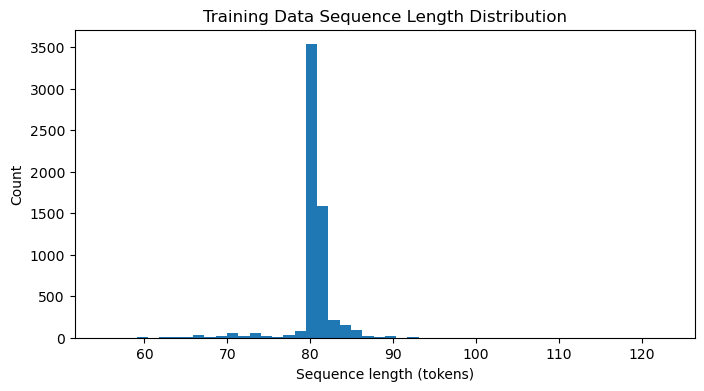

In [32]:
# EDA
%matplotlib inline

# add a length column
train['length'] = train['text'].apply(len)

# summary statistics
print("Length stats:\n", train['length'].describe())

# histogram
plt.figure(figsize=(8, 4))
plt.hist(train['length'], bins=50)
plt.xlabel('Sequence length (tokens)')
plt.ylabel('Count')
plt.title('Training Data Sequence Length Distribution')
plt.show()


### Method 1: Bag-of-Words + TF–IDF Baseline with Class-Weighted Logistic Regression

##### Prepare text strings for TF-IDF input

In [33]:
# Convert token sequences into strings
train['text_str'] = train['text'].apply(lambda seq: ' '.join(map(str, seq)))
df_test['text_str'] = df_test['text'].apply(lambda seq: ' '.join(map(str, seq)))

train[['id', 'label', 'domain', 'text_str']].head() # inspect examples

,id,label,domain,text_str
0,0,0,domain1,6 22 34 76 501 977 1 2514 13623 76 31 2085 277...
1,1,0,domain1,222 31 4108 104 132 361 39 2305 12 936 1287 66...
2,2,0,domain1,736 7194 113 12 366 2870 123 101 12 230 403 51...
3,3,0,domain1,48 1 2025 69 361 533 327 237 4150 13 22 2128 1...
4,4,0,domain1,2973 66 1 1493 260 2740 50 1027 50 1 3289 69 5...


##### Split dataframe and vectorize with TF–IDF

In [34]:
# Split the combined DataFrame into df_train and df_val
df_train, df_val = train_test_split(
    train,
    test_size=0.2,
    stratify=train['label'],
    random_state=42
)

# Extract labels
y_train = df_train['label'].values
y_val   = df_val['label'].values

# Fit TF-IDF on the training text_str
vectorizer = TfidfVectorizer(max_features=20000)
X_train_tf = vectorizer.fit_transform(df_train['text_str'])
X_val_tf   = vectorizer.transform(df_val['text_str'])
X_test_tf  = vectorizer.transform(df_test['text_str'])

print("TF-IDF shapes:")
print("  X_train_tf:", X_train_tf.shape)
print("  X_val_tf:  ", X_val_tf.shape)
print("  X_test_tf: ", X_test_tf.shape)


TF-IDF shapes:
  X_train_tf: (4800, 15633)
  X_val_tf:   (1200, 15633)
  X_test_tf:  (4000, 15633)


##### Evaluate log-regression baseline

In [35]:
# Train and evaluate a class-weighted Logistic Regression baseline
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Fit on training TF-IDF features
clf.fit(X_train_tf, y_train)

# Predict on validation set
y_pred = clf.predict(X_val_tf)

# Evaluate
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))


Validation Accuracy: 0.9258

Classification Report:
              precision    recall  f1-score   support

           0     0.6580    0.8467    0.7405       150
           1     0.9772    0.9371    0.9567      1050

    accuracy                         0.9258      1200
   macro avg     0.8176    0.8919    0.8486      1200
weighted avg     0.9373    0.9258    0.9297      1200



##### 5-Fold cross-validation of TF–IDF + logistic regression baseline

In [36]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000)),
    ('clf',  LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline,
    train['text_str'],
    train['label'],
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("CV accuracies per fold:", scores)
print(f"Mean CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

CV accuracies per fold: [0.90583333 0.925      0.92       0.91333333 0.92916667]
Mean CV accuracy: 0.9187 ± 0.0083


##### Hyperparameter Tuning: GridSearchCV on TF–IDF + LR

In [37]:
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(train['text_str'], train['label'])

print("Best CV Accuracy: {:.4f}".format(grid_search.best_score_))
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV Accuracy: 0.9413
Best Parameters: {'clf__C': 10, 'tfidf__ngram_range': (1, 2)}


##### Re-evaluate model after hyperparameter tuning

In [38]:
# Evaluate tuned model on hold-out validation set
best_pipe = grid_search.best_estimator_
X_val_tuned = best_pipe.named_steps['tfidf'].transform(df_val['text_str'])
y_val_pred = best_pipe.named_steps['clf'].predict(X_val_tuned)

print("Hold-out Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=4))


Hold-out Validation Accuracy: 0.97
              precision    recall  f1-score   support

           0     0.8065    1.0000    0.8929       150
           1     1.0000    0.9657    0.9826      1050

    accuracy                         0.9700      1200
   macro avg     0.9032    0.9829    0.9377      1200
weighted avg     0.9758    0.9700    0.9713      1200



##### Threshold tuning for tuned TF–IDF + Logistic Regression

In [39]:
best_pipe = grid_search.best_estimator_

prob_human = best_pipe.predict_proba(df_val['text_str'])[:, 0]

thresholds = np.linspace(0.1, 0.9, 17)
print("Threshold | Precision (human) | Recall (human) | F1 (human)")
for t in thresholds:
    preds = np.where(prob_human >= t, 0, 1)
    prec = precision_score(y_val, preds, pos_label=0)
    rec  = recall_score(y_val, preds, pos_label=0)
    f1   = f1_score(y_val, preds, pos_label=0)
    print(f"  {t:.2f}    |   {prec:.4f}         |   {rec:.4f}     |  {f1:.4f}")

Threshold | Precision (human) | Recall (human) | F1 (human)
  0.10    |   0.5515         |   1.0000     |  0.7109
  0.15    |   0.6726         |   1.0000     |  0.8043
  0.20    |   0.7317         |   1.0000     |  0.8451
  0.25    |   0.7772         |   1.0000     |  0.8746
  0.30    |   0.7937         |   1.0000     |  0.8850
  0.35    |   0.7979         |   1.0000     |  0.8876
  0.40    |   0.7979         |   1.0000     |  0.8876
  0.45    |   0.8021         |   1.0000     |  0.8902
  0.50    |   0.8065         |   1.0000     |  0.8929
  0.55    |   0.8065         |   1.0000     |  0.8929
  0.60    |   0.8287         |   1.0000     |  0.9063
  0.65    |   0.8324         |   0.9933     |  0.9058
  0.70    |   0.9800         |   0.9800     |  0.9800
  0.75    |   0.9862         |   0.9533     |  0.9695
  0.80    |   1.0000         |   0.9333     |  0.9655
  0.85    |   1.0000         |   0.9000     |  0.9474
  0.90    |   1.0000         |   0.8200     |  0.9011


In [40]:
best_ngram = (1, 2)
best_C     = 10

pipeline_tuned = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=best_ngram)),
    ('clf',  LogisticRegression(class_weight='balanced', C=best_C, max_iter=1000, random_state=42))
])

pipeline_tuned.fit(df_train['text_str'], df_train['label'])

prob_human = pipeline_tuned.predict_proba(df_val['text_str'])[:, 0]

threshold = 0.70
preds_val = np.where(prob_human >= threshold, 0, 1)

# Evaluate
print(f"Validation Accuracy (threshold = {threshold:.2f}): {accuracy_score(y_val, preds_val):.4f}\n")
print("Classification Report:")
print(classification_report(y_val, preds_val, digits=4))

Validation Accuracy (threshold = 0.70): 0.9608

Classification Report:
              precision    recall  f1-score   support

           0     0.9640    0.7133    0.8199       150
           1     0.9605    0.9962    0.9780      1050

    accuracy                         0.9608      1200
   macro avg     0.9622    0.8548    0.8990      1200
weighted avg     0.9609    0.9608    0.9583      1200



##### SMOTE on Domain 2’s Human Class

In [41]:
from scipy.sparse import vstack, csr_matrix
from imblearn.over_sampling import SMOTE

In [42]:
# Extract TF–IDF vectorizer and optimal C from the tuned pipeline
vectorizer = best_pipe.named_steps['tfidf']
C_opt      = best_pipe.named_steps['clf'].C

# Transform train/validation into feature matrices
X_train_all = vectorizer.transform(df_train['text_str'])
X_val_tf    = vectorizer.transform(df_val['text_str'])
y_train_all = df_train['label'].values

# Select Domain 2 subset
mask_dom2 = df_train['domain'] == 'domain2'
X_dom2    = X_train_all[mask_dom2].toarray()
y_dom2    = y_train_all[mask_dom2]

# Apply SMOTE on Domain 2 human class (label 0)
smote = SMOTE(random_state=42)
X_dom2_res, y_dom2_res = smote.fit_resample(X_dom2, y_dom2)

# Re-combine with Domain 1 unchanged
mask_dom1    = ~mask_dom2
X_dom1       = X_train_all[mask_dom1]
y_dom1       = y_train_all[mask_dom1]
X_dom2_res_sp = csr_matrix(X_dom2_res)

X_res = vstack([X_dom1, X_dom2_res_sp])
y_res = np.concatenate([y_dom1, y_dom2_res])

# Retrain Logistic Regression on SMOTE-augmented data
clf_smote = LogisticRegression(class_weight='balanced',
                               C=C_opt,
                               max_iter=1000,
                               random_state=42)
clf_smote.fit(X_res, y_res)

# Predict on validation using threshold = 0.70
prob_hum_smote = clf_smote.predict_proba(X_val_tf)[:, 0]
preds_smote    = np.where(prob_hum_smote >= 0.70, 0, 1)

# Evaluate
print("SMOTE (Domain2 Human) Validation Accuracy:", accuracy_score(y_val, preds_smote))
print("\nClassification Report:")
print(classification_report(y_val, preds_smote, digits=4))

SMOTE (Domain2 Human) Validation Accuracy: 0.9308333333333333

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.4467    0.6175       150
           1     0.9267    1.0000    0.9620      1050

    accuracy                         0.9308      1200
   macro avg     0.9634    0.7233    0.7897      1200
weighted avg     0.9359    0.9308    0.9189      1200



##### Threshold tuning

In [43]:
X_val_tf = vectorizer.transform(df_val['text_str'])

# Get human-written probabilities from your SMOTE-trained classifier
prob_human_smote = clf_smote.predict_proba(X_val_tf)[:, 0]

# Sweep thresholds and report metrics for the human class
thresholds = np.linspace(0.1, 0.9, 17)
print("Threshold | Precision(0) | Recall(0) | F1(0)")
for t in thresholds:
    preds = np.where(prob_human_smote >= t, 0, 1)
    prec  = precision_score(y_val, preds, pos_label=0)
    rec   = recall_score(y_val, preds, pos_label=0)
    f1    = f1_score(y_val, preds, pos_label=0)
    print(f"  {t:.2f}    |  {prec:.4f}   |   {rec:.4f}  |  {f1:.4f}")

Threshold | Precision(0) | Recall(0) | F1(0)
  0.10    |  0.5771   |   0.9733  |  0.7246
  0.15    |  0.6425   |   0.9467  |  0.7655
  0.20    |  0.6935   |   0.9200  |  0.7908
  0.25    |  0.7377   |   0.9000  |  0.8108
  0.30    |  0.7616   |   0.8733  |  0.8137
  0.35    |  0.9394   |   0.8267  |  0.8794
  0.40    |  0.9417   |   0.7533  |  0.8370
  0.45    |  0.9722   |   0.7000  |  0.8140
  0.50    |  0.9898   |   0.6467  |  0.7823
  0.55    |  0.9889   |   0.5933  |  0.7417
  0.60    |  1.0000   |   0.5533  |  0.7124
  0.65    |  1.0000   |   0.5000  |  0.6667
  0.70    |  1.0000   |   0.4467  |  0.6175
  0.75    |  1.0000   |   0.3933  |  0.5646
  0.80    |  1.0000   |   0.3467  |  0.5149
  0.85    |  1.0000   |   0.3267  |  0.4925
  0.90    |  1.0000   |   0.3000  |  0.4615


In [44]:
threshold = 0.35
preds = np.where(prob_human_smote >= threshold, 0, 1)

print(f"SMOTE Model Accuracy (threshold = {threshold:.2f}):",
      accuracy_score(y_val, preds))
print("\nClassification Report:")
print(classification_report(y_val, preds, digits=4))

SMOTE Model Accuracy (threshold = 0.35): 0.9716666666666667

Classification Report:
              precision    recall  f1-score   support

           0     0.9394    0.8267    0.8794       150
           1     0.9757    0.9924    0.9839      1050

    accuracy                         0.9717      1200
   macro avg     0.9575    0.9095    0.9317      1200
weighted avg     0.9711    0.9717    0.9709      1200



In [ ]:
submission_smote = pd.DataFrame({
    'id': df_test['id'], 
    'class': preds_test
    })
submission_smote.to_csv('smote_submission.csv', index=False)

# 7. Preview the first few rows
submission_smote.head()